# NOTE

- Make a copy of this template before you start editing, and exported the file as a ipynb where you are done.

- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Runtime$\rightarrow$Factory reset runtime) and then **run all cells** (in the menubar, select Runtime$\rightarrow$Run all).

- Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE". Fill out your name below in the `NAME` variable, leave the `COLLABORATORS` variable empty.

In [234]:
NAME = "Payal Mantri"
COLLABORATORS = ""

---

# Homework 5

## Copy number callers



In this homework assignment we will develop a copy number caller based on a Hidden Markov Model. In addition, we will implement a hierarchical clustering algorithm. The data that we consider is from a previously published [breast tumor](http://dx.doi.org/10.1038/nature09807), from which 100 single cells have been sequenced. In this homework assignment we restrict our attention to a subset of 25 cells.

_Instructions:_ There are four questions, worth a total of 100 points. In addition, there are two bonus questions (Q2e and Q4c), each worth 5 points. Insert your answer after each question in the designated box. Replace comments with code.


In [235]:
# Install library and download data

! pip install nose
! pip install numpy
! pip install pandas
! pip install matplotlib



In [236]:
# ! wget -c 'https://drive.google.com/uc?export=download&id=12pgHOpJ8sRzF_rcnGE-xjAx3Eacu5W97' -O data.zip
# ! unzip -o data.zip

In [237]:
! unzip -o 'HW5_supplement.zip'

Archive:  HW5_supplement.zip
  inflating: data.tsv                
  inflating: data_filtered_test.csv  


In [238]:
import copy
import sys

import nose.tools as nt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import logsumexp
from scipy.stats import norm
from scipy.cluster import hierarchy

## Question 1: Data preparation [20 points]

We start by parsing the data from `data.tsv` using pandas.

In [239]:
df = pd.read_csv("data.tsv", sep="\t", index_col=0)
print(df.shape)
df.head()

(5363, 28)


,CHR,START,END,SRR089377,SRR054598,SRR053605,SRR054594,SRR089397,SRR054614,SRR089402,...,SRR054606,SRR054613,SRR053631,SRR054575,SRR053679,SRR054604,SRR053611,SRR053607,SRR053602,SRR054610
bin,,,,,,,,,,,,,,,,,,,,,
0,chr1,1,1246396,2116,298,573,157,3146,1495,4071,...,854,1583,1106,1847,795,562,1211,636,751,1520
1,chr1,1246395,1833664,1940,264,660,204,1643,1207,3809,...,651,848,1252,2024,830,584,836,475,673,1185
2,chr1,1833663,2345598,1767,261,870,237,1655,1621,5418,...,707,1372,1342,2531,1153,874,936,630,818,1366
3,chr1,2345597,2946628,2246,446,854,265,1564,1838,5625,...,1227,1172,1578,2909,1373,884,1184,604,973,1701
4,chr1,2946627,3452945,2189,363,883,217,2081,1173,4845,...,687,1371,1562,3235,1053,854,785,649,784,1212


This dataset consists of the following 25 cells:

In [240]:
cells = list(df.columns[3:])
print(cells)
sys.stdout.write("Cells:")
for idx, cell in enumerate(cells):
    if idx % 5 == 0:
        sys.stdout.write("\n")
    sys.stdout.write(cell + " ")

['SRR089377', 'SRR054598', 'SRR053605', 'SRR054594', 'SRR089397', 'SRR054614', 'SRR089402', 'SRR053676', 'SRR053633', 'SRR053617', 'SRR054608', 'SRR053608', 'SRR054602', 'SRR089401', 'SRR053668', 'SRR054606', 'SRR054613', 'SRR053631', 'SRR054575', 'SRR053679', 'SRR054604', 'SRR053611', 'SRR053607', 'SRR053602', 'SRR054610']
Cells:
SRR089377 SRR054598 SRR053605 SRR054594 SRR089397 
SRR054614 SRR089402 SRR053676 SRR053633 SRR053617 
SRR054608 SRR053608 SRR054602 SRR089401 SRR053668 
SRR054606 SRR054613 SRR053631 SRR054575 SRR053679 
SRR054604 SRR053611 SRR053607 SRR053602 SRR054610 

The reads of each cell are put in bins. As seen in the command below, there are 5363 bins.

In [241]:
len(df.index)


5363

In [242]:
df.shape

(5363, 28)

We plot a histogram of the bin sizes as follows, from which we can see that most of the bins have length 500,000.

(400000.0, 1000000.0)

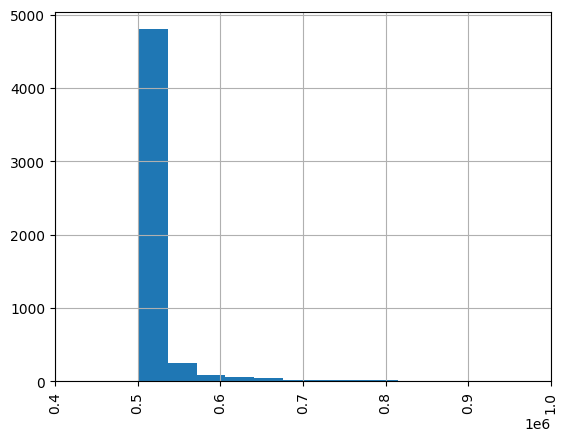

In [243]:
(df['END'] - df['START'] + 1).hist(bins=1000, xrot=90)
plt.xlim((400000, 1000000))

### _Q1a:_ What is the minimum, median and maximum bin size? [4 points]

Set the values of `minimum`, `median`, and `maximum` according to the minimum, median and maximum bin size.

In [244]:
df['END'] - df['START'] 

bin
0        1246395
1         587269
2         511935
3         601031
4         506318
          ...   
5358      540089
5359      762445
5360      571356
5361      685916
5362    35387247
Length: 5363, dtype: int64

In [245]:
minimum, median, maximum = min(df['END'] - df['START'] +1), np.median(df['END'] - df['START'] + 1), max(df['END'] - df['START'] + 1)
print(minimum, median, maximum)

501688 514870.0 35387248


In [246]:
# HIDDEN TEST CELL DO NOT MODIFY


In [247]:
# HIDDEN TEST CELL DO NOT MODIFY


In [248]:
# HIDDEN TEST CELL DO NOT MODIFY


We retain bins with lengths between 450,000 and 500,000 using the following command.

In [249]:
df = df[(450000 <= (df['END'] - df['START'] + 1)) & ((df['END'] - df['START'] + 1) <= 550000)]

In [250]:
df.shape

(4949, 28)

In [251]:
print(np.unique(df.CHR))

['chr1' 'chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17'
 'chr18' 'chr19' 'chr2' 'chr20' 'chr21' 'chr22' 'chr3' 'chr4' 'chr5'
 'chr6' 'chr7' 'chr8' 'chr9' 'chrX' 'chrY']


### _Q1b:_ The column `CHR` contains the chromosome label. Do these cells originate from a male or female patient? [4 points]

Write code here to print unique list of values in `'CHR'` column, this should give you the information you need.

Set the value of `is_female` to `True` or `False` based on the answer to this question.

In [252]:

is_female = 'chrY' not in np.unique(df.CHR)

print(is_female)

False


In [253]:
# HIDDEN TEST CELL DO NOT MODIFY


Next, we remove the sex chromosomes such that each bin in a normal cell has copy number 2.

### _Q1c:_ How many bins occur on autosomal chromosomes? [4 points]

Insert code to generate a list of chromosome labels corresponding to autosomes, e.g. `['chr1', 'chr2', ...]`.

The value of `autosomal_bins` is set to the number of bins that are in this list.

In [254]:
# Make a list of autosomes
chromosomes = np.unique(df.CHR)
autosomes = [x for x in chromosomes if (x != 'chrX' and x!='chrY')]
print(autosomes)
# YOUR CODE HERE


autosomal_bins = len(df[df['CHR'].isin(autosomes)])
# print(autosomal_bins)

['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9']


In [255]:
print(autosomal_bins)

4718


In [256]:

# HIDDEN TEST CELL DO NOT MODIFY


In [257]:
# Now retain only autosomes
df_auto = df[df['CHR'].isin(autosomes)]
df_auto.head

<bound method NDFrame.head of         CHR     START       END  SRR089377  SRR054598  SRR053605  SRR054594  \
bin                                                                           
2      chr1   1833663   2345598       1767        261        870        237   
4      chr1   2946627   3452945       2189        363        883        217   
6      chr1   4112609   4622985       2449        325        915        196   
7      chr1   4622984   5133470       2084        283        834        263   
8      chr1   5133469   5640704       1994        294        937        219   
...     ...       ...       ...        ...        ...        ...        ...   
5060  chr22  47566819  48078854       2255        532        776        404   
5061  chr22  48078853  48585535       2149        561        759        388   
5062  chr22  48585534  49094378       2135        495        863        345   
5063  chr22  49094377  49609038       2233        518        883        396   
5064  chr22  49609037 


Due to variablity in library preparation, there are differences in the total number of reads per cell. We construct a new dataframe with the total number of reads, and plot a histogram as follows.

,cell,total
0,SRR089377,9584016
1,SRR054598,1784898
2,SRR053605,3807854
3,SRR054594,1361308
4,SRR089397,8634326


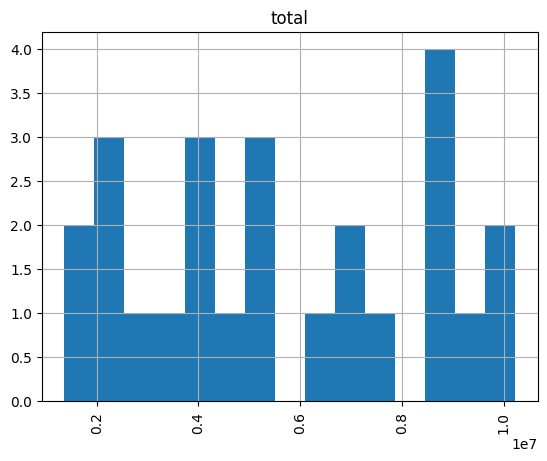

In [258]:
df_total_reads = pd.DataFrame.from_records([(cell, int(df_auto[cell].sum())) for cell in cells], columns=['cell', 'total'])
df_total_reads.hist(column="total", bins=15, xrot=90)
df_total_reads.head()

### _Q1d:_ Based on the above plot, we decide to exclude the six cells with a total read count of less than 3,000,000 reads. Which six cells are excluded? [4 points]

You are given the code for the cells that we include.

Set `df_removed_cells` to a DataFrame corresponding to the excluded cells, i.e. those with total read count of less than 3,000,000 reads. Note the type of `df_removed_cells` is not the same as that of `cells_to_keep`, which is a list. Rather, `df_removed_cells` is a DataFrame with two columns `'cell'` representing the name of the cell and `'total'` corresponding with the total read count of that cell.

Specifically, it should be the case that:
    `type(df_removed_cells) == type(df_total_reads)`

In [259]:
# insert code to filter down to cells with less 3,000,000 reads

cells_to_keep = list(df_total_reads[df_total_reads['total'] >= 3000000]['cell'])
print(cells_to_keep)
df_removed_cells = df_total_reads[~df_total_reads['cell'].isin(cells_to_keep)]
print(df_removed_cells)


['SRR089377', 'SRR053605', 'SRR089397', 'SRR054614', 'SRR089402', 'SRR053633', 'SRR053617', 'SRR054608', 'SRR053608', 'SRR054602', 'SRR089401', 'SRR053668', 'SRR054606', 'SRR054613', 'SRR053631', 'SRR054575', 'SRR053611', 'SRR053602', 'SRR054610']
         cell    total
1   SRR054598  1784898
3   SRR054594  1361308
7   SRR053676  2036366
19  SRR053679  2021242
20  SRR054604  2473778
22  SRR053607  2784633


In [260]:
# HIDDEN TEST CELL DO NOT MODIFY


In [261]:
# we retain only cells with >= 300,000 reads
df_auto = df_auto[list(df_auto.columns)[:3] + cells_to_keep]
df_auto.shape

(4718, 22)

### _Q1e:_ Complete the below code fragment to identify the mode of each cell and to subsequently normalize the read counts. [4 points]

The key concept is that the majority of bins in a cell are diploid. Since the bins have the same length and under the assumption of uniform genome coverage, we expect the most frequent read count, or the mode, to correspond to the diploid state. We identify the mode by discretizing the read counts for each cell into 20 bins. We then divide the read count for each bin in a cell by the mode.

Make sure to discretize first prior to computing mode. The goal is to have 20 distinct values of reads counts per cell, this allows you to obtain the mode more robustly. To do so, for each cell, you must first identify the largest number of reads. Then, you divide the largest number of reads by 20 (use integer division). Then you need to round down your original number of reads to the nearest discretized number of reads (again possible using integer division).

Please put the result of dividing the read counts in `df_auto` into `df_filter`.

In [262]:
import math;
nr_bins = 20

# Use df2 to discretize read count
df2 = df_auto.copy(deep=True)

# Use df_filter to normalize
df_filter = df_auto.copy(deep=True)

for cell in cells_to_keep:
    print(int(np.max(df[cell])/nr_bins))
    bin_size = int(np.max(df[cell])/nr_bins)
    df2[cell] = (df2[cell] / bin_size).astype(int) * bin_size
    
    # insert code to discretize read count (e.g. first integer division by bin_size, then multiply by bin_size)
    # YOUR CODE HERE
df_mode = pd.DataFrame.from_records([(cell, int(df2[cell].mode())) for cell in cells_to_keep], 
                                    columns=['cell', 'mode'])
print("mode")
print(df_mode)
# insert code to divide each read count in df_filter by the mode of the corresponding cell
for cell in cells_to_keep:
    mode= df_mode.loc[df_mode['cell'] == cell, 'mode'].values[0]
    df_filter[cell] = df_filter[cell] / df_mode[df_mode['cell'] == cell]['mode'].iloc[0]
    # YOUR CODE HERE
    # raise NotImplementedError()

153
66
158
327
327
173
85
218
50
223
322
76
137
248
209
196
110
68
280
mode
         cell  mode
0   SRR089377  1989
1   SRR053605   792
2   SRR089397  1738
3   SRR054614  1962
4   SRR089402   981
5   SRR053633  1730
6   SRR053617  1020
7   SRR054608  1308
8   SRR053608   650
9   SRR054602  1115
10  SRR089401   966
11  SRR053668   988
12  SRR054606   548
13  SRR054613  1488
14  SRR053631  1254
15  SRR054575   588
16  SRR053611   990
17  SRR053602   748
18  SRR054610  1680


In [263]:
df_filter.head()

,CHR,START,END,SRR089377,SRR053605,SRR089397,SRR054614,SRR089402,SRR053633,SRR053617,...,SRR054602,SRR089401,SRR053668,SRR054606,SRR054613,SRR053631,SRR054575,SRR053611,SRR053602,SRR054610
bin,,,,,,,,,,,,,,,,,,,,,
2,chr1,1833663,2345598,0.888386,1.098485,0.952244,0.826198,5.522936,1.115029,1.055882,...,0.805381,3.628364,1.122470,1.290146,0.922043,1.070175,4.304422,0.945455,1.093583,0.813095
4,chr1,2946627,3452945,1.100553,1.114899,1.197353,0.597859,4.938838,1.034682,1.147059,...,0.765919,3.318841,0.974696,1.253650,0.921371,1.245614,5.501701,0.792929,1.048128,0.721429
6,chr1,4112609,4622985,1.231272,1.155303,1.207135,0.780836,6.683996,1.348555,1.276471,...,0.947982,4.175983,1.065789,1.293796,0.936828,1.454545,5.103741,1.136364,1.172460,0.783929
7,chr1,4622984,5133470,1.047763,1.053030,1.133487,0.804791,5.490316,1.136994,1.087255,...,0.844843,3.906832,1.135628,1.458029,0.807124,1.275120,4.784014,1.095960,1.085561,0.749405
8,chr1,5133469,5640704,1.002514,1.183081,1.288838,0.734455,5.291539,1.271098,1.126471,...,0.764126,3.367495,1.229757,1.177007,0.667339,1.310207,4.250000,1.048485,1.192513,0.952976


In [264]:
# HIDDEN TEST CELL DO NOT MODIFY


In [265]:
# The following commented out code generates data_filtered.tsv, which is part of the zip file of this assignment. 
# If your code is correct the resulting file should be identical to the provided file.
df_filter.to_csv("my_data_filtered_normalized.tsv", sep="\t")

## Question 2: Viterbi algorithm [50 points]

In this question we use the Viterbi algorithm to compute a copy number for each bin. The set $Q$ of hidden states corresponds to integer copy numbers. We consider $Q=\{0,\ldots,10\}$. The set $\Sigma$ of emitted symbols are normalized read counts. Since this an infinite set, we use a probability distribution function for each integer copy number to define the emission probabilities. Specifically, for copy number $c \in \{0,\ldots,10\}$ we use a normal distribution with standard deviation $\sigma = 0.1$ centered around mean $\mu_c = c / 2$.

In [266]:
df_norm = pd.read_table("data_filtered_test.csv", sep="\t", index_col=0)

In [267]:
df_norm.head()

,CHR,START,END,SRR089377,SRR053605,SRR089397,SRR054614,SRR089402,SRR053633,SRR053617,...,SRR054602,SRR089401,SRR053668,SRR054606,SRR054613,SRR053631,SRR054575,SRR053611,SRR053602,SRR054610
bin,,,,,,,,,,,,,,,,,,,,,
2,chr1,1833663,2345598,0.883058,1.095718,0.951149,1.237405,5.511699,1.111175,1.049708,...,0.804659,3.628364,1.119072,1.287796,0.918955,1.066773,4.304422,0.941650,1.084881,0.812128
4,chr1,2946627,3452945,1.093953,1.112091,1.195977,0.895420,4.928789,1.031106,1.140351,...,0.765233,3.318841,0.971746,1.251366,0.918285,1.241653,5.501701,0.789738,1.039788,0.720571
6,chr1,4112609,4622985,1.223888,1.152393,1.205747,1.169466,6.670397,1.343894,1.269006,...,0.947133,4.175983,1.062563,1.291439,0.933691,1.449921,5.103741,1.131791,1.163130,0.782996
7,chr1,4622984,5133470,1.041479,1.050378,1.132184,1.205344,5.479145,1.133065,1.080897,...,0.844086,3.906832,1.132190,1.455373,0.804421,1.271065,4.784014,1.091549,1.076923,0.748514
8,chr1,5133469,5640704,0.996502,1.180101,1.287356,1.100000,5.280773,1.266705,1.119883,...,0.763441,3.367495,1.226034,1.174863,0.665104,1.306041,4.250000,1.044266,1.183024,0.951843


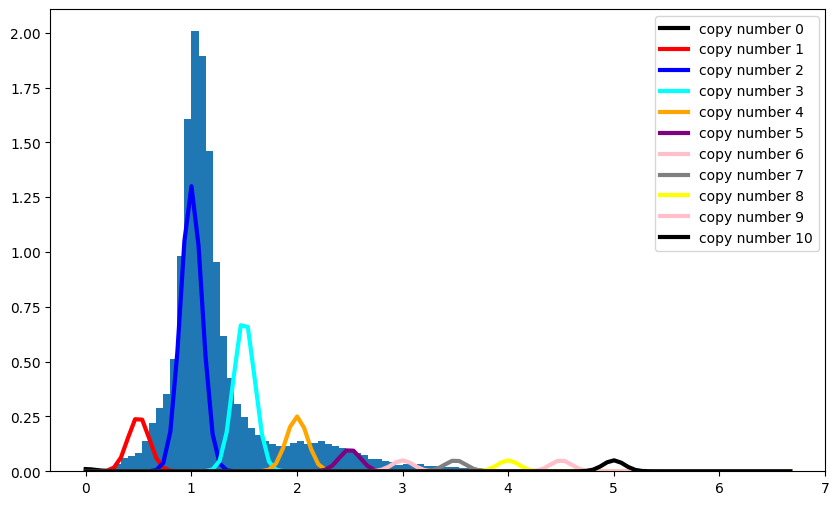

In [268]:
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

values = [val for sublist in [list(df_norm[cell]) for cell in list(df_norm.columns[3:])] for val in sublist]
count, bins, ignored = plt.hist(values, 100, density=True)

sigma = 0.1

plt.plot(np.array([0,.05,.1,.15,.2]),gauss(np.array([0,.05,.1,.15,.2]), 0, sigma, .01),color='black',lw=3,label='copy number 0')
plt.plot(bins,gauss(bins, 0.5, sigma, .25),color='red',lw=3,label='copy number 1')
plt.plot(bins,gauss(bins, 1, sigma, 1.3),color='blue',lw=3,label='copy number 2')
plt.plot(bins,gauss(bins, 1.5, sigma, .7),color='cyan',lw=3,label='copy number 3')
plt.plot(bins,gauss(bins, 2, sigma, .25),color='orange',lw=3,label='copy number 4')
plt.plot(bins,gauss(bins, 2.5, sigma, .1),color='purple',lw=3,label='copy number 5')
plt.plot(bins,gauss(bins, 3, sigma, .05),color='pink',lw=3,label='copy number 6')
plt.plot(bins,gauss(bins, 3.5, sigma, .05),color='gray',lw=3,label='copy number 7')
plt.plot(bins,gauss(bins, 4, sigma, .05),color='yellow',lw=3,label='copy number 8')
plt.plot(bins,gauss(bins, 4.5, sigma, .05),color='pink',lw=3,label='copy number 9')
plt.plot(bins,gauss(bins, 5, sigma, .05),color='black',lw=3,label='copy number 10')

plt.legend()
plt.gcf().set_size_inches(10, 6)

In [269]:
max_copy_number = 10

def emissionLogProb(copy_number, norm_count):
    sigma = 0.1
    mu = copy_number / 2.

    # Compute Pr(|X_c - norm_count| <= 0.01 | c)  
    low = norm.cdf(norm_count - 0.01, mu, sigma)
    up = norm.cdf(norm_count + 0.01, mu, sigma)
    
    # prevent probability of 0
    prob = max(up - low, 0.0001)
    
    return np.log(prob)

def transitionLogProb(current_copy_number, next_copy_number):
    stay_prob = 0.99999
    if current_copy_number == next_copy_number:
        return np.log(stay_prob)
    elif 0 <= next_copy_number <= max_copy_number:
        return np.log((1 - stay_prob) / max_copy_number)
    else:
        return np.log(0)

def initialLogProb(copy_number):
    if 0 <= copy_number <= max_copy_number:
        return np.log(1./11)
    else:
        return np.log(0)

### _Q2a:_ Compute the joint log probability of each cell having copy number 2 in all bins. [10 points]

_Hint:_ Make use of the functions `emissionLogProb`, `initialLogProb` and `transitionLogProb` to set the values in the dictionary `joint_log_prob`. 

In [270]:
initialLogProb(2)

-2.3978952727983707

In [271]:
emissionLogProb(10, 0.88)

-9.210340371976182

In [272]:
joint_log_prob = {k:0.0 for k in list(df_norm.columns[3:])}



for cell in list(df_norm.columns[3:]):
    log_prob = 0
    for idx, norm_count in df_norm[cell].items():
        # Hint: idx == df_norm.index[0] is the initial item.
        # YOUR CODE HERE
        if idx == df_norm.index[0]:
            log_prob = initialLogProb(2)+emissionLogProb(2, norm_count)
        else:
            # max = np.max([v[prev_copy_number][bins[idx-1]] + transitionLogProb(prev_copy_number, curr_copy_number) for prev_copy_number in Q])
            log_prob += transitionLogProb(2,2)+emissionLogProb(2, norm_count)
    joint_log_prob[cell] = log_prob
    print(cell, log_prob)
print

SRR089377 -15135.070967101623
SRR053605 -15545.0612914526
SRR089397 -15308.765158061895
SRR054614 -34822.82444699966
SRR089402 -37630.92651885531
SRR053633 -17806.476991176896
SRR053617 -16345.749228000472
SRR054608 -28616.21503369759
SRR053608 -16321.148713950497
SRR054602 -29995.409906001376
SRR089401 -35739.67290677184
SRR053668 -23637.079259670103
SRR054606 -36717.05414486559
SRR054613 -28292.024336094033
SRR053631 -21570.613114390424
SRR054575 -34596.789039112264
SRR053611 -15312.762620957486
SRR053602 -18026.71904371433
SRR054610 -28578.42393018763


<function print>

In [273]:
# HIDDEN TEST CELL DO NOT MODIFY


### _Q2b:_ Determine the maximum joint log probability of each cell using the Viterbi algorithm. [20 points]

Complete the function `viterbi`, making use of the functions `emissionLogProb`, `initialLogProb` and `transitionLogProb`.

Then complete the `max_joint_prob` function. The values in the `max_joint_probability` dictionary are filled in after you complete these two functions. This dictionary is autograded.

In [274]:
def viterbi(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization v[copy_number][bin] = 0
    v = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]
    
    for idx, bin in enumerate(bins):
        norm_count = float(df_norm.loc[bin][cell])
        
        for curr_copy_number in Q:
            if idx == 0:
                v[curr_copy_number][bin] = initialLogProb(curr_copy_number) + emissionLogProb(curr_copy_number, norm_count)
            else:
                # get max value from previous bin and add transition and emission probabilities
                max = np.max([v[prev_copy_number][bins[idx-1]] + transitionLogProb(prev_copy_number, curr_copy_number) for prev_copy_number in Q])
                v[curr_copy_number][bin] = emissionLogProb(curr_copy_number, norm_count) + max
        
    return v

def max_joint_prob(df_norm, v):
    # Positions
    bins = sorted(list(df_norm.index))
    
    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    last_bin = bins[-1]

   
    
    max_joint_probability = np.max([v[copy_number][last_bin] for copy_number in Q])
    return max_joint_probability

max_joint_probability = {}
V = {}
for cell in list(df_norm.columns[3:]):
    V[cell] = viterbi(df_norm, cell)
    max_joint_probability[cell] = max_joint_prob(df_norm, V[cell])
    print(cell, max_joint_probability[cell])

SRR089377 -15135.07096710289
SRR053605 -15545.061291453789
SRR089397 -15308.765158063214


In [ ]:
max_joint_probability

{'SRR089377': -15135.07096710289,
 'SRR053605': -15545.061291453789,
 'SRR089397': -15308.765158063214,
 'SRR054614': -21459.85971466328,
 'SRR089402': -26926.698867515544,
 'SRR053633': -17806.476991178395,
 'SRR053617': -16345.74922800195,
 'SRR054608': -21893.73594081532,
 'SRR053608': -16321.148713951978,
 'SRR054602': -22052.950647001708,
 'SRR089401': -25818.24091555924,
 'SRR053668': -17933.50037237371,
 'SRR054606': -25598.446215727326,
 'SRR054613': -21730.2333361158,
 'SRR053631': -21461.508174337996,
 'SRR054575': -26713.527991256262,
 'SRR053611': -15312.762620958683,
 'SRR053602': -18024.067571223906,
 'SRR054610': -21836.19569778152}

In [ ]:
# HIDDEN TEST CELL DO NOT MODIFY


### _Q2c:_ Compute the most likely copy number profile for each cell. [10 points]

_Hint:_ Hint perform a backtrace or extend the above `viterbi` function to maintain backpointers.

In [ ]:
def viterbi_bt(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization v[copy_number][bin] = 0
    v = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]
    bt = [ { bin : None for bin in bins } for c in range(max_copy_number + 1) ]
    
    for idx, bin in enumerate(bins):
        norm_count = float(df_norm.loc[bin][cell])
        for curr_copy_number in Q:
            if idx == 0:
                v[curr_copy_number][bin] = initialLogProb(curr_copy_number) + emissionLogProb(curr_copy_number, norm_count)
                bt[curr_copy_number][bin] = -1
            else:
                max_val = v[Q[0]][bins[idx-1]] + transitionLogProb(Q[0], curr_copy_number)
                bt[curr_copy_number][bin] = 0
                for prev_copy_number in Q[1:]:
                    curr_val = v[prev_copy_number][bins[idx-1]] + transitionLogProb(prev_copy_number, curr_copy_number)
                    if max_val < curr_val:
                        max_val = curr_val
                        bt[curr_copy_number][bin] = prev_copy_number
                v[curr_copy_number][bin] = emissionLogProb(curr_copy_number, norm_count) + max_val
    return v, bt
    

bins = sorted(list(df_norm.index))
Q = range(max_copy_number+1)

V = {}
BT = {}
C = {}
max_joint_probability = {}
for cell in list(df_norm.columns[3:]):
    V[cell], BT[cell] = viterbi_bt(df_norm, cell)
    C[cell] = {}
    
    max_prob = max_joint_prob(df_norm, V[cell])
    final_c = None
    final_bin = bins[-1]
    for c in Q:
        if V[cell][c][final_bin] == max_prob:
            final_c = c
    
    C[cell][final_bin] = final_c
    
    for idx in range(len(bins)-2, -1, -1):
        bin = bins[idx]
        next_bin = bins[idx + 1]
        next_bin_c = C[cell][next_bin]
        C[cell][bin] = BT[cell][next_bin_c][next_bin]
    
    max_joint_probability[cell] = max_prob
    print(cell, "--", "max prob:", max_prob)

SRR089377 -- max prob: -15135.07096710289
SRR053605 -- max prob: -15545.061291453789
SRR089397 -- max prob: -15308.765158063214
SRR054614 -- max prob: -21459.85971466328
SRR089402 -- max prob: -26926.698867515544
SRR053633 -- max prob: -17806.476991178395
SRR053617 -- max prob: -16345.74922800195
SRR054608 -- max prob: -21893.73594081532
SRR053608 -- max prob: -16321.148713951978
SRR054602 -- max prob: -22052.950647001708
SRR089401 -- max prob: -25818.24091555924
SRR053668 -- max prob: -17933.50037237371
SRR054606 -- max prob: -25598.446215727326
SRR054613 -- max prob: -21730.2333361158
SRR053631 -- max prob: -21461.508174337996
SRR054575 -- max prob: -26713.527991256262
SRR053611 -- max prob: -15312.762620958683
SRR053602 -- max prob: -18024.067571223906
SRR054610 -- max prob: -21836.19569778152


In [ ]:
# HIDDEN TEST CELL DO NOT MODIFY


### _Q2d:_ Which cells are normal cells (i.e. have copy number 2 for each bin)? [10 points]

Use `visualizeCopyNumbers(C, bins)` to set the value of `num_normal_cells`.


In [ ]:
bins = sorted(list(df_norm.index))

In [ ]:
def visualizeCopyNumbers(C, bins):
    nrRows = 5
    nrCols = 4
    for idx, cell in enumerate(C):
        ax = plt.subplot(nrRows, nrCols, idx+1)
        plt.step(list(range(len(bins))), list(C[cell].values()))
        ax.set_title(cell)
        ax.set_ylim((0, 10))
        ax.set_xlabel("bin")
        ax.set_ylabel("copy number")
    plt.gcf().set_size_inches(30, 20)
    plt.tight_layout()
    plt.savefig("viterbi.pdf")

The following cells have a copy number of 2:
SRR089377
SRR053605
SRR089397
SRR053633
SRR053617
SRR053608
SRR053611


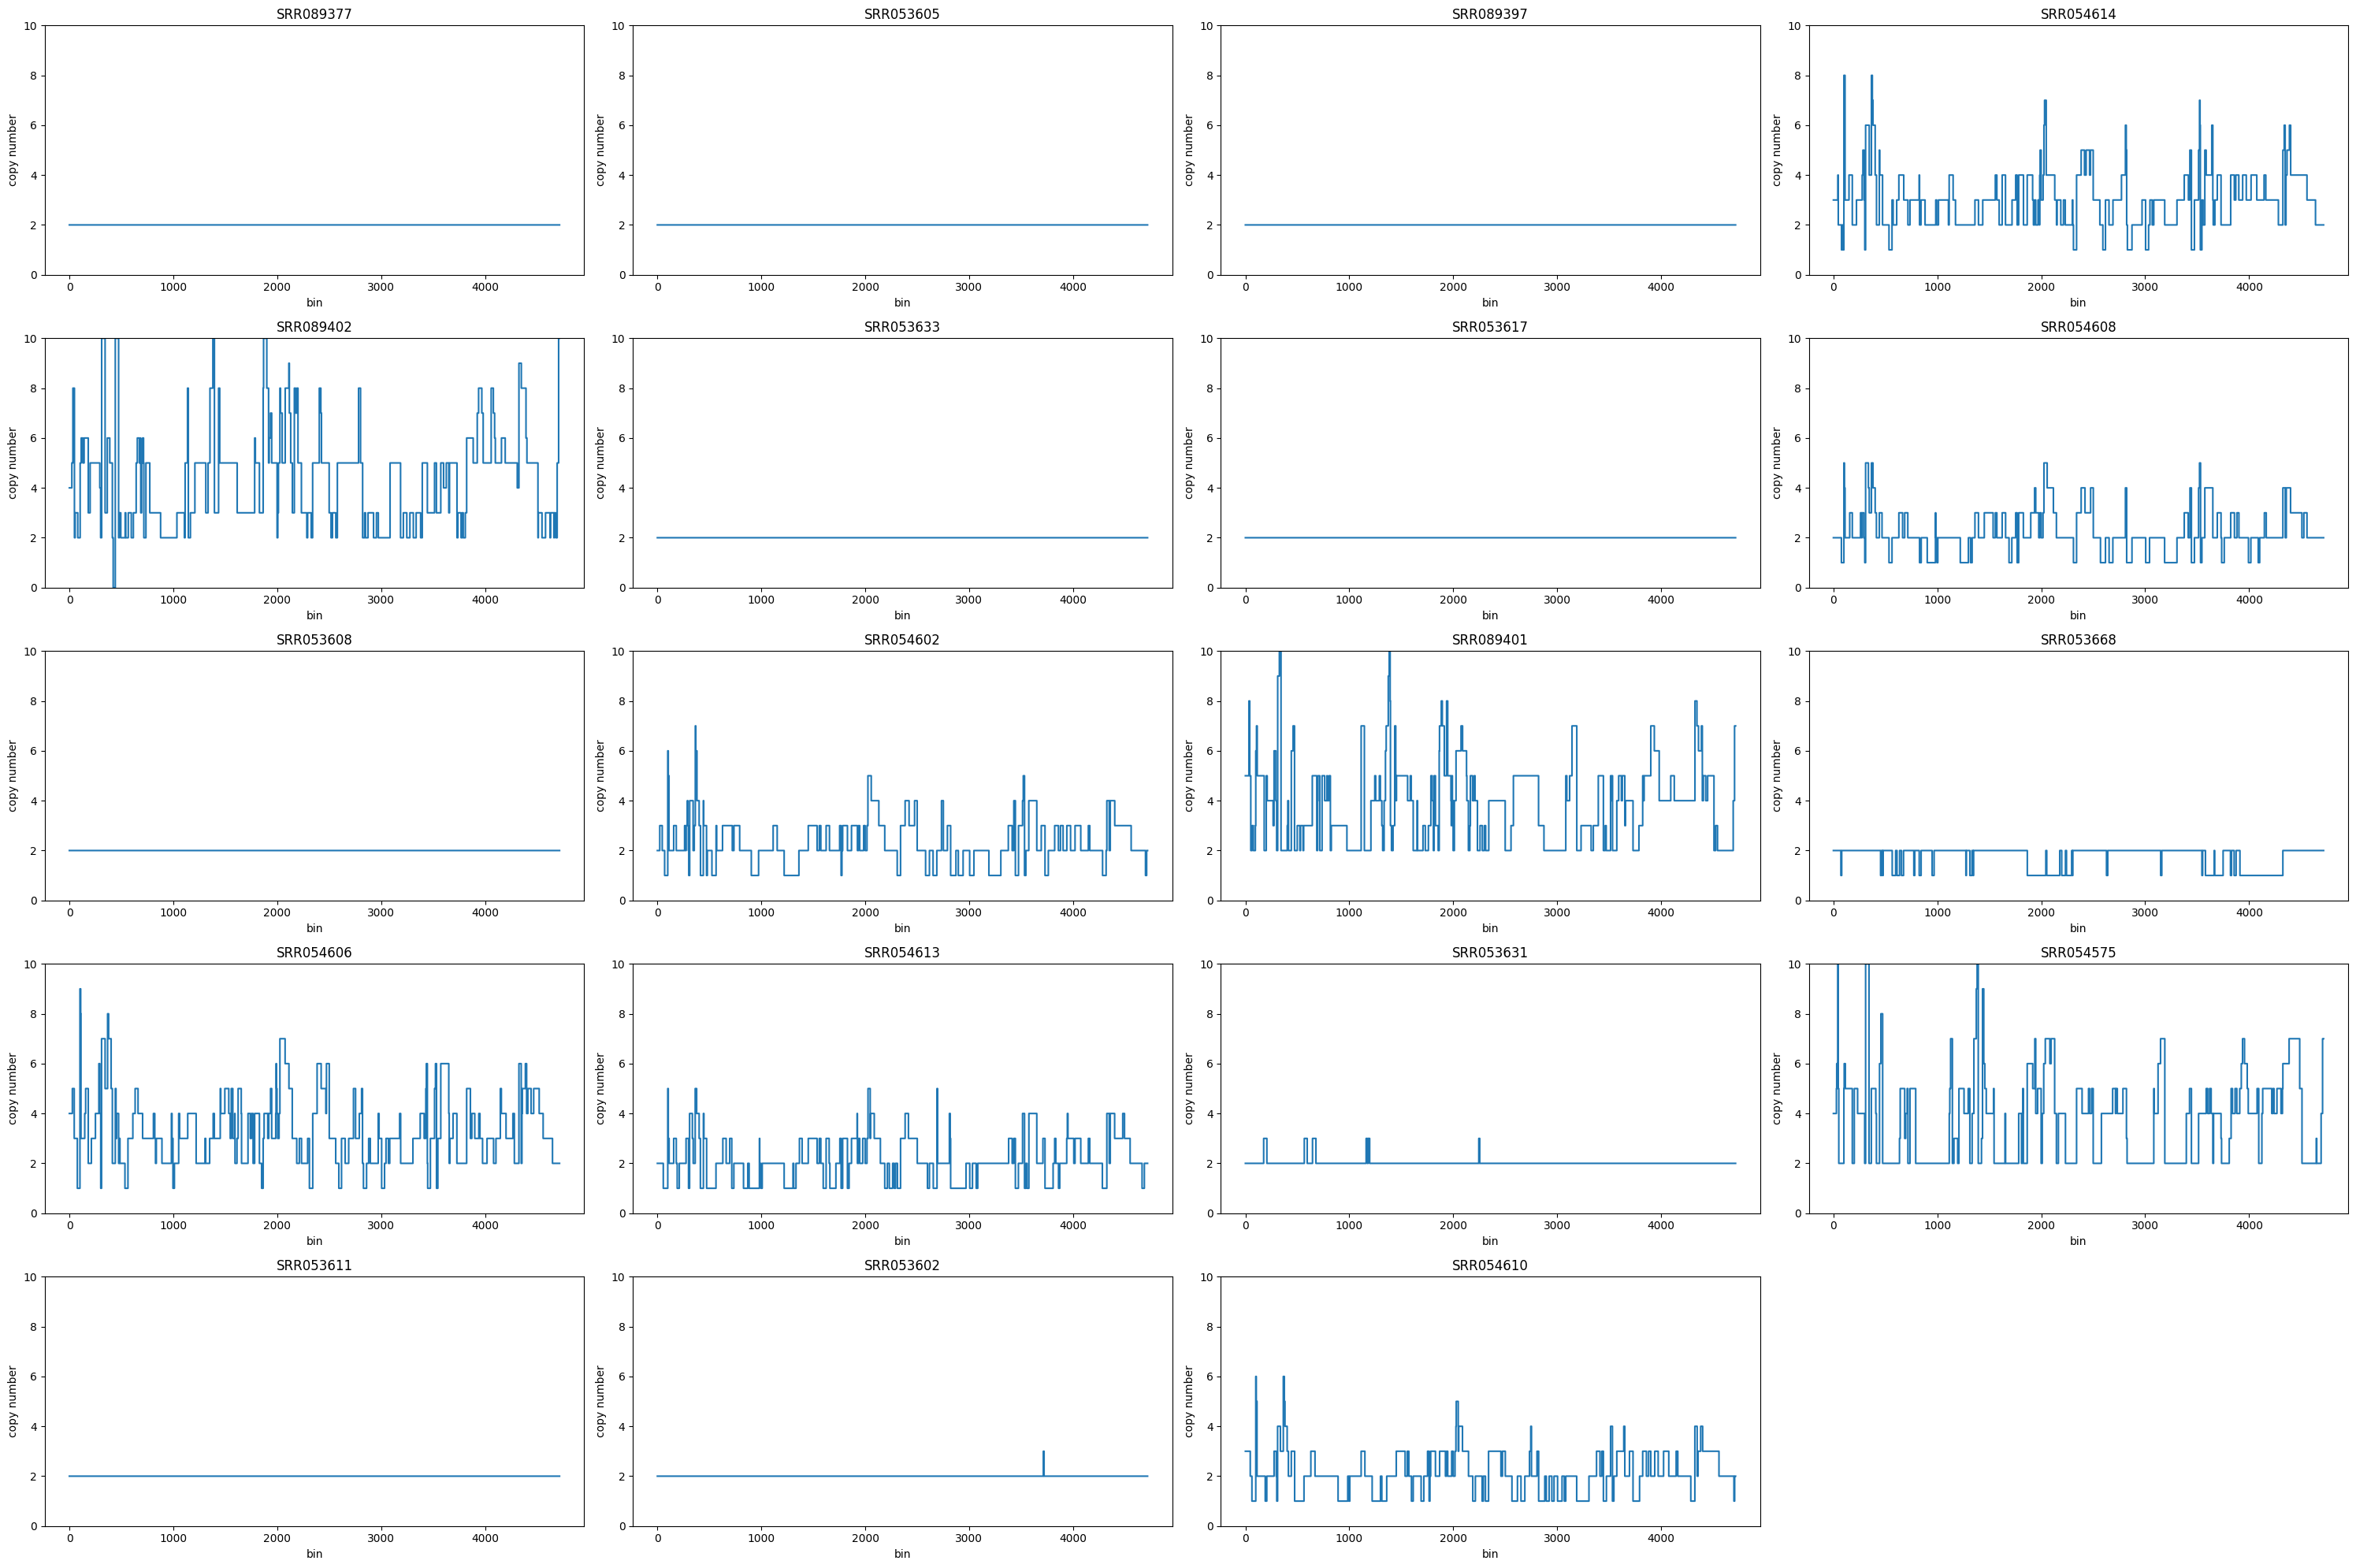

In [ ]:
visualizeCopyNumbers(C, bins)
num_normal_cells = 0
print("The following cells have a copy number of 2:")
for cell in C.keys():
    copy_numbers = list(C[cell].values())
    
    # check if all elements in copy numbers are the same
    if all(x == copy_numbers[0] for x in copy_numbers):
        num_normal_cells += 1
        print(cell)
    
   

In [ ]:
# HIDDEN TEST CELL DO NOT MODIFY


### _Q2e -- Bonus:_ Extend the plotting function to delineate chromosomes using vertical lines.  [5 points]

- Do not forget to update x-axis labels to show chromosomes.
- The output of 2e should be similar to 2d except with vertical delineations. 
- Generate the plot in the cell below.

In [ ]:
temp_df = df_norm.copy(deep=True)
temp_df = temp_df.sort_index()
grouped = temp_df.groupby('CHR').groups
chrom_location = {}
for name, group in grouped.items():
    chrom_location[name] = temp_df.index.get_loc(group.max())
def visualizeCopyNumbers(C, bins):
    nrRows = 5
    nrCols = 4
    sorted_locs = sorted(list(chrom_location.values()))
    for idx, cell in enumerate(C):
        ax = plt.subplot(nrRows, nrCols, idx+1)
        plt.step(range(len(bins)), list(C[cell].values()))
        plt.xticks(sorted_locs, range(1, 23, 1))
        ax.set_title(cell)
        ax.set_ylim((0, 10))
        ax.set_xlabel("chromosomes")
        ax.set_ylabel("copy number")
        for chrom, location in chrom_location.items():
            ax.axvline(x=location, label=chrom)
    plt.gcf().set_size_inches(30, 20)
    plt.tight_layout()
    plt.savefig("viterbi.pdf")



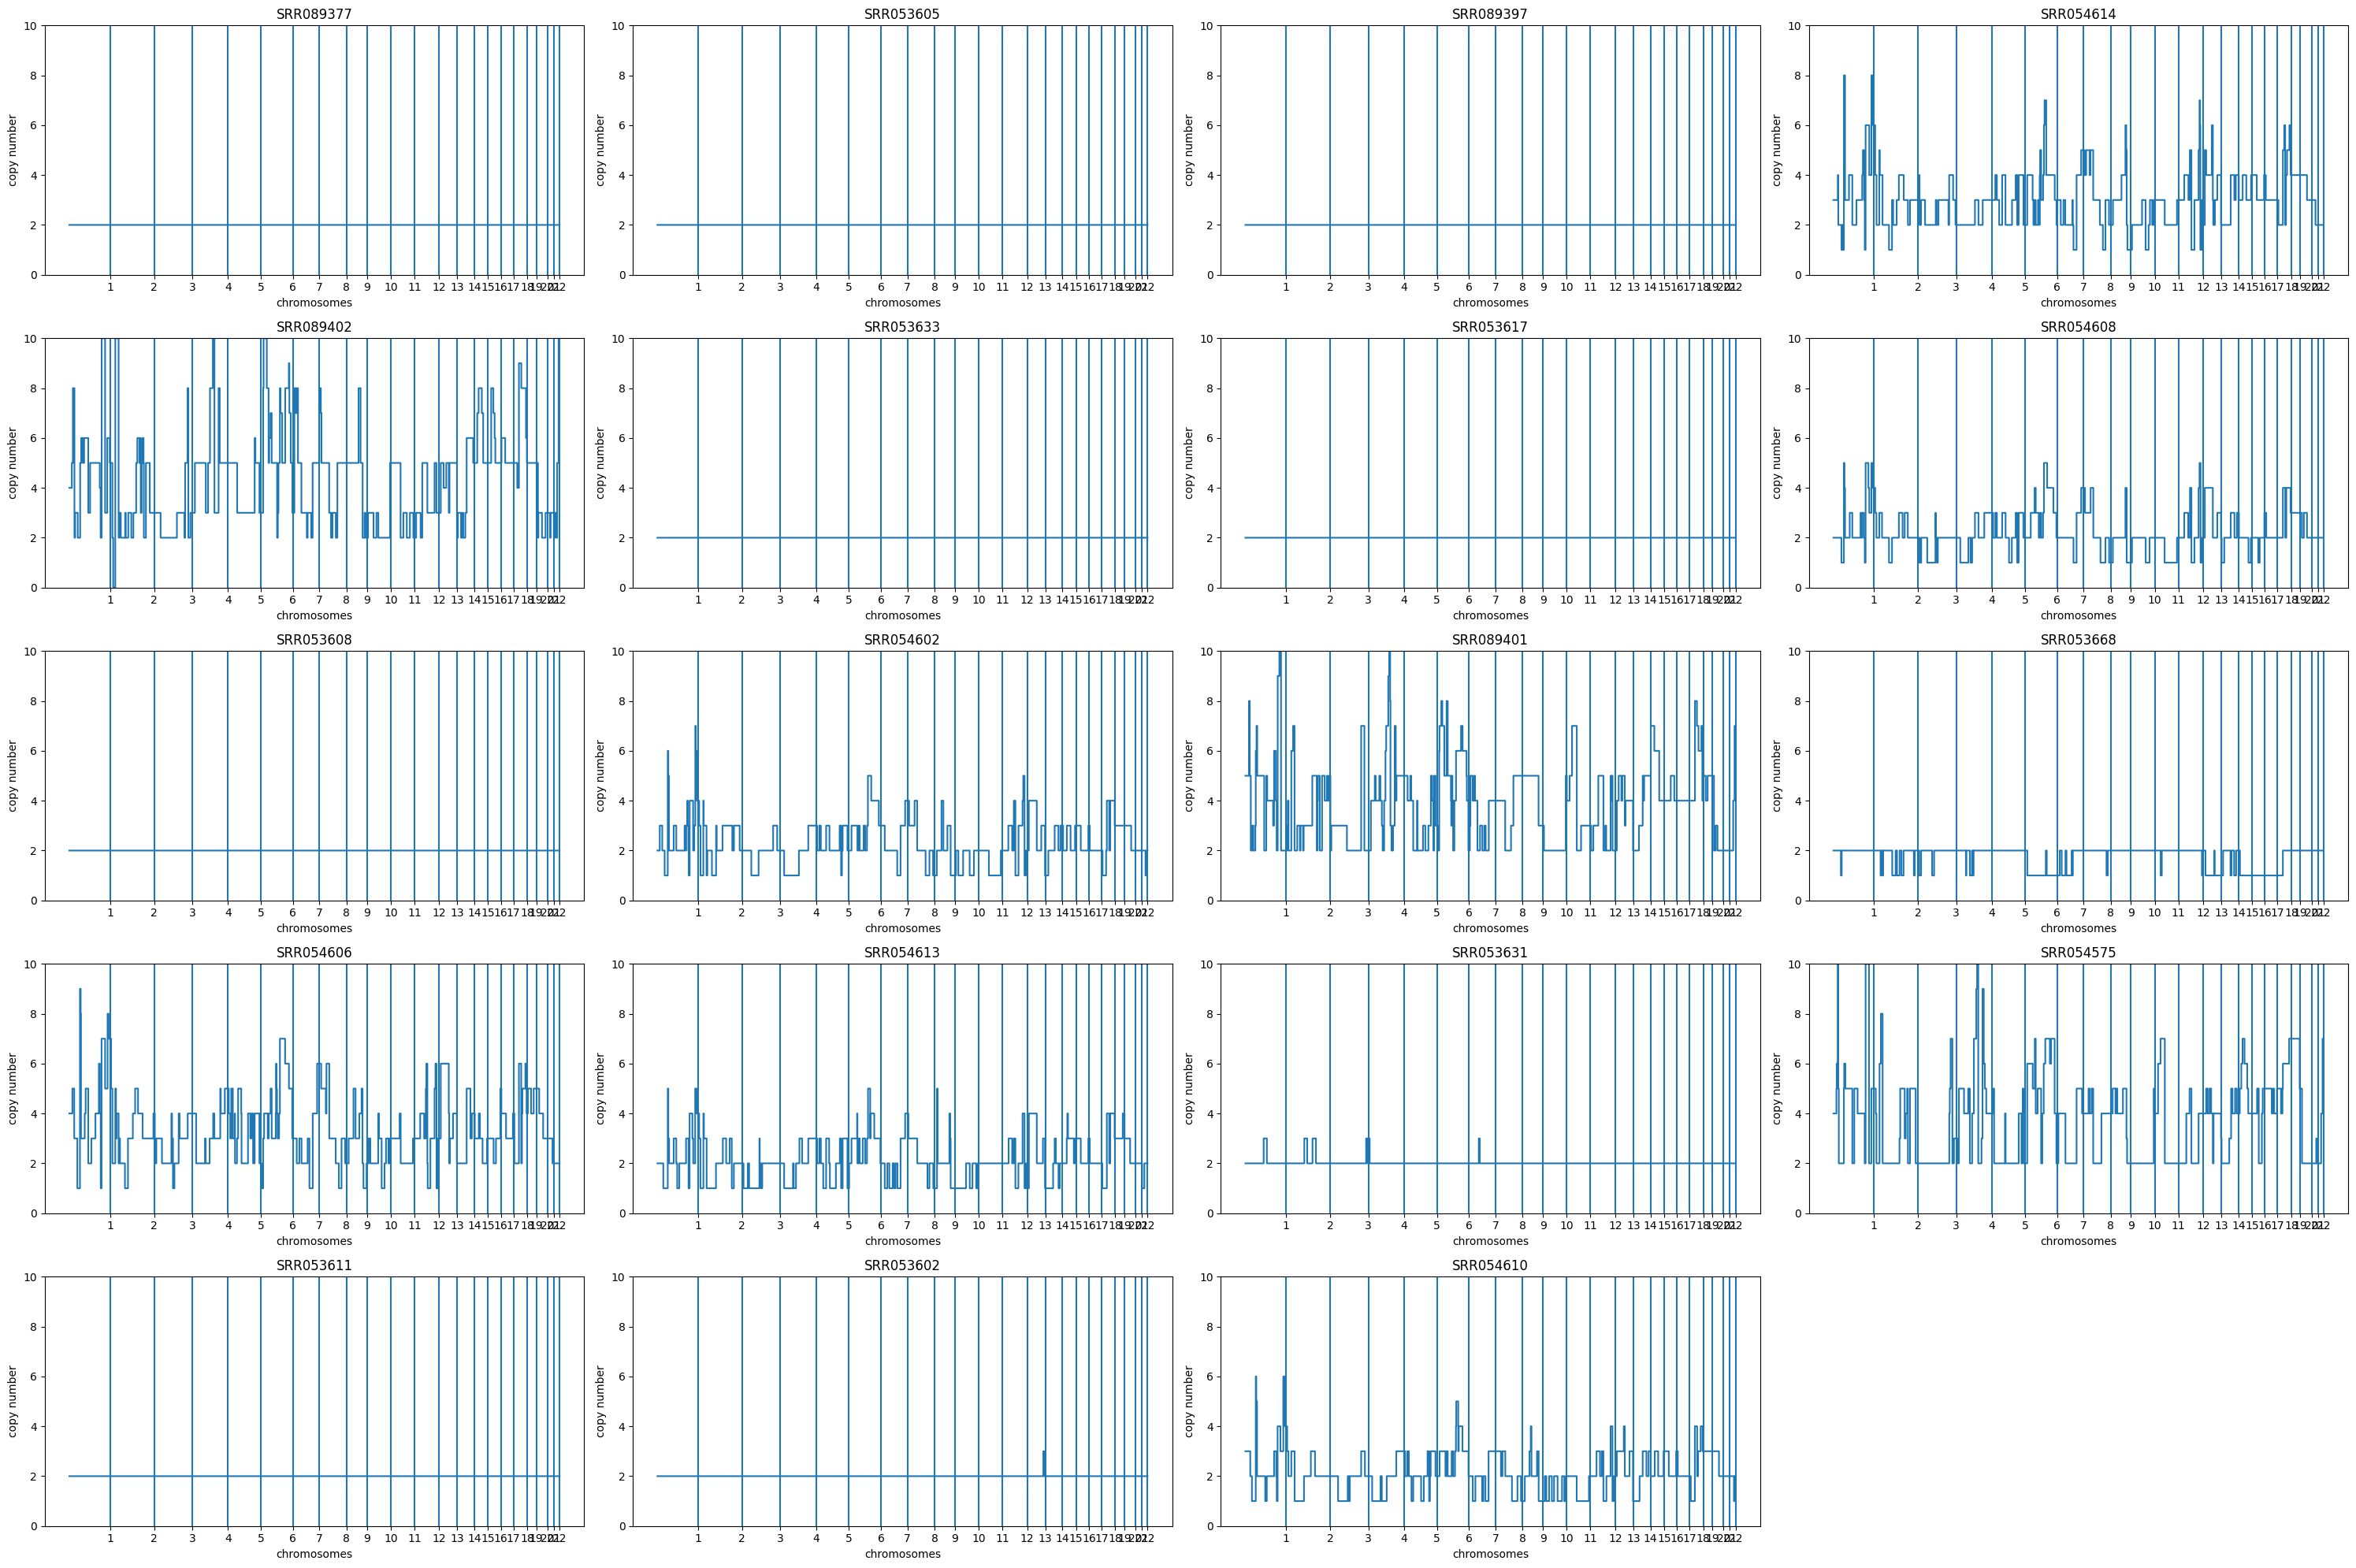

In [ ]:
visualizeCopyNumbers(C, bins)

## Question 3: Forward algorithm [10 points]

### _Q3a:_ Compute the marginal log probability of the observations using the forward algorithm. [10 points]

Complete the `forward` and `marginal_log_prob` functions defined below.

Be aware that recurrence of the forward algorithm includes a summation, but we are operating in log space.

You may find `logsumexp` in scipy useful, and you can find more details [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logsumexp.html).

In [ ]:
len(list(df_norm.index))

4718

In [ ]:
def forward(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization f[copy_number][bin] = 0
    f = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]
   

    for idx, bin in enumerate(bins):
        norm_count = float(df_norm.loc[bin][cell])
        
        for curr_copy_number in Q:
            if (idx == 0):
                f[curr_copy_number][bin] = initialLogProb(curr_copy_number) + emissionLogProb(curr_copy_number, norm_count)
            else:
                prev_bin = bins[idx-1]
                f[curr_copy_number][bin] = emissionLogProb(curr_copy_number, norm_count) + logsumexp([f[prev_copy_number][prev_bin] + transitionLogProb(prev_copy_number, curr_copy_number) for prev_copy_number in Q[1:]]) 
    return f

def marginal_log_prob(df_norm, f):
    # Positions
    bins = sorted(list(df_norm.index))
    
    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    last_bin = bins[-1]
    
    marginal_log_probability = None
    # YOUR CODE HERE
    marginal_log_prob = 0
    # add log probabilities of all copy numbers at the last bin
  
   
    marginal_log_prob= logsumexp([f[copy_number][last_bin] for copy_number in Q])
        
    return marginal_log_prob

F = {}
marginal_log_probability = {}
for cell in list(df_norm.columns[3:]):
    F[cell] = forward(df_norm, cell)
    marginal_log_probability[cell] = marginal_log_prob(df_norm, F[cell])
    print(cell, "--", "marginal log prob:", marginal_log_probability[cell])

SRR089377 -- marginal log prob: -15135.070967017358
SRR053605 -- marginal log prob: -15544.611184874737
SRR089397 -- marginal log prob: -15308.76515788818
SRR054614 -- marginal log prob: -21413.9621603122
SRR089402 -- marginal log prob: -26973.244313268995
SRR053633 -- marginal log prob: -17806.467586959607
SRR053617 -- marginal log prob: -16345.748979993878
SRR054608 -- marginal log prob: -21866.800724293076
SRR053608 -- marginal log prob: -16321.148713466358
SRR054602 -- marginal log prob: -22021.285090054927
SRR089401 -- marginal log prob: -25755.432572147827
SRR053668 -- marginal log prob: -17925.966970602196
SRR054606 -- marginal log prob: -25538.887682480974
SRR054613 -- marginal log prob: -21695.728249091804
SRR053631 -- marginal log prob: -21456.659057566234
SRR054575 -- marginal log prob: -26652.33063027506
SRR053611 -- marginal log prob: -15312.762620820406
SRR053602 -- marginal log prob: -18023.959457069246
SRR054610 -- marginal log prob: -21801.796204376813


In [ ]:
marginal_log_probability

{}

In [ ]:
# HIDDEN TEST CELL DO NOT MODIFY


## Question 4: Hierarchical clustering [20 points]
The Python package `scipy` implements hierarchical clustering. We will use this method to perform single linkage cluster with the Manhattan (also known as cityblock) distance metric.

In [ ]:
C_labels = list(C.keys())
C_values = [list(C[cell].values()) for cell in C_labels]

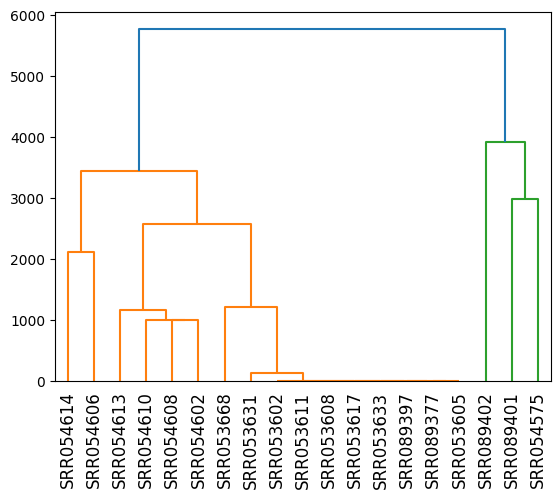

In [ ]:
Z = hierarchy.linkage(C_values, 'single', 'cityblock')
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)
plt.show()

The goal of this question is to reimplement this algorithm. We start by computing the initial distance matrix.

### _Q4a:_ Compute the initial distance matrix using Manhattan distance. [10 points]

In [ ]:
def manhattan(C, cell_1, cell_2, bins):
    manhat_dist = 0
    for bin in bins:
        manhat_dist += (abs(C[cell_1][bin] - C[cell_2][bin]))
    return manhat_dist
    

bins = sorted(list(df_norm.index))
dist = {}
for cell_1 in C.keys():
    dist[cell_1] = {}
    for cell_2 in C.keys():
        dist[cell_1][cell_2] = manhattan(C, cell_1, cell_2, bins)

In [ ]:
# HIDDEN TEST CELL DO NOT MODIFY


In [ ]:
# sort keys in dictionary order
set(sorted(dist.keys()))



{'SRR053602',
 'SRR053605',
 'SRR053608',
 'SRR053611',
 'SRR053617',
 'SRR053631',
 'SRR053633',
 'SRR053668',
 'SRR054575',
 'SRR054602',
 'SRR054606',
 'SRR054608',
 'SRR054610',
 'SRR054613',
 'SRR054614',
 'SRR089377',
 'SRR089397',
 'SRR089401',
 'SRR089402'}

In [ ]:
dist['SRR053605']

{'SRR089377': 0,
 'SRR053605': 0,
 'SRR089397': 0,
 'SRR054614': 5202,
 'SRR089402': 11122,
 'SRR053633': 0,
 'SRR053617': 0,
 'SRR054608': 2584,
 'SRR053608': 0,
 'SRR054602': 3041,
 'SRR089401': 8689,
 'SRR053668': 1207,
 'SRR054606': 6653,
 'SRR054613': 2926,
 'SRR053631': 128,
 'SRR054575': 7980,
 'SRR053611': 0,
 'SRR053602': 7,
 'SRR054610': 2695}

### _Q4b:_ Implement single linkage clustering. [10 points]
_Hint:_ The documentation for the required output format is described here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

In [ ]:
def find_min(distances, cluster1,cluster2):
    min =distances[cluster1[0]][cluster2[0]]
    for point1 in cluster1:
        for point2 in cluster2:
            dis = distances[point1][point2]
            if dis < min:
                min = dis
    return min

def cluster(distances):
    distances = copy.deepcopy(distances)
    # sorted list of clusters keys
    clusters = set(sorted(distances.keys()))
    # list of clusters  keys

   
    print(clusters)
    n = len(clusters)
    cluster2idx = { cell : idx for idx, cell in enumerate(clusters) }
    idx2cluster = [ cell for cell in clusters ]

    Z = np.empty((0, 4), float)
    membership = [ set([cluster2idx[cell]]) for cell in clusters ]
   
    while len(clusters) > 1:
        # TODO: identify pair (c1, c2) with minimum distance dist


        dist, c1, c2 = None, None, None
        for cell_1 in clusters:
            for cell_2 in clusters:
                if cell_1 != cell_2:
                    if dist is None or dist > distances[cell_1][cell_2]:
                        dist = distances[cell_1][cell_2]
                        c1 = cell_1
                        c2 = cell_2
                    elif dist == distances[cell_1][cell_2]:
                        # if distance is same, choose the pair with small alphabetically combination
                        if c1 + c2 > cell_1 + cell_2:
                            c1 = cell_1
                            c2 = cell_2
        idx_c1 = cluster2idx[c1]
        idx_c2 = cluster2idx[c2]
        new_cluster = str(n + len(Z))
      
        new_cluster_idx = len(idx2cluster)
        
        membership.append( membership[idx_c1] | membership[idx_c2])
        
        Z = np.append(Z, 
                      np.array([[cluster2idx[c1], cluster2idx[c2], dist, len(membership[new_cluster_idx])]]), 
                      axis=0)
        # print(cluster2idx[c1], cluster2idx[c2], dist, len(membership[new_cluster_idx]), "\"", membership[idx_c1] | membership[idx_c2], sorted(membership[idx_c1] | membership[idx_c2])) 
        
        distances[new_cluster] = {}
        for cell in clusters:
            if cell != new_cluster:

                min_dist = None
                for cell_1_ix in membership[new_cluster_idx]:
                  for cell_2_ix in membership[cluster2idx[cell]]:
                    cell_1 = idx2cluster[cell_1_ix]
                    cell_2 = idx2cluster[cell_2_ix]
                    if (min_dist == None) or (min_dist > distances[cell_1][cell_2]) :
                        min_dist = distances[cell_1][cell_2]
                distances[new_cluster][cell] = min_dist
                distances[cell][new_cluster] = distances[new_cluster][cell]

        # YOUR CODE HERE
    
        clusters.add(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)
        
        clusters.remove(c1)
        clusters.remove(c2)
    # print("Z", Z,idx2cluster[:n])
    return Z, idx2cluster[:n]

{'SRR054613', 'SRR053631', 'SRR054608', 'SRR053611', 'SRR054614', 'SRR054602', 'SRR053617', 'SRR054610', 'SRR089402', 'SRR054606', 'SRR089397', 'SRR053605', 'SRR089377', 'SRR089401', 'SRR053668', 'SRR053602', 'SRR053608', 'SRR053633', 'SRR054575'}


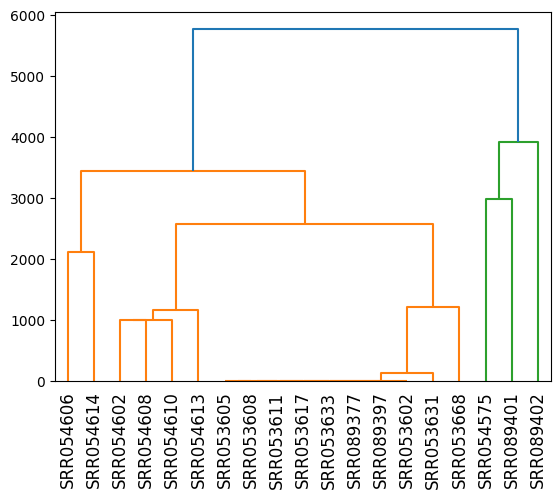

In [ ]:
Z, labels = cluster(dist)

plt.figure()
dn = hierarchy.dendrogram(Z, labels=labels, leaf_rotation=90)
plt.show()

In [ ]:
# HIDDEN TEST CELL DO NOT MODIFY


### _Q4c :_ Implement complete linkage clustering. [5 points]
_Hint:_ The documentation for the required output format is described here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage. Your plot should be identical to the below scipy plot.

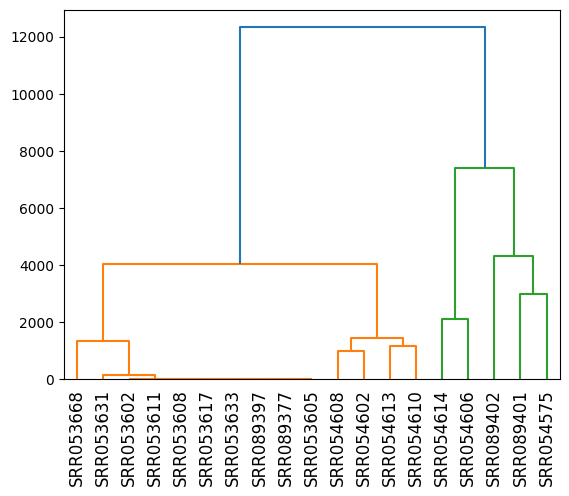

In [ ]:
Z = hierarchy.linkage(C_values, 'complete', 'cityblock')
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)
plt.show()

In [ ]:
def complete_cluster(distances):
    distances = copy.deepcopy(distances)
    clusters = set(sorted(distances.keys()))
    n = len(clusters)
    cluster2idx = { cell : idx for idx, cell in enumerate(clusters) }
    idx2cluster = [ cell for cell in clusters ]
    Z = np.empty((0, 4), float)
    membership = [ set([cluster2idx[cell]]) for cell in clusters ]
    while len(clusters) > 1:
        # TODO: identify pair (c1, c2) with minimum distance dist
        dist, c1, c2 = None, None, None
        for cell_1 in clusters:
            for cell_2 in clusters:
                if cell_1 != cell_2:
                    if dist is None or dist > distances[cell_1][cell_2]:
                        dist = distances[cell_1][cell_2]
                        c1 = cell_1
                        c2 = cell_2
                    elif dist == distances[cell_1][cell_2]:
                        # if distance is same, choose the pair with small alphabetically combination
                        if c1 + c2 > cell_1 + cell_2:
                            c1 = cell_1
                            c2 = cell_2
        idx_c1 = cluster2idx[c1]
        idx_c2 = cluster2idx[c2]
        new_cluster = str(n + len(Z))
        new_cluster_idx = len(idx2cluster)
        membership.append( membership[idx_c1] | membership[idx_c2])
        Z = np.append(Z, 
                      np.array([[cluster2idx[c1], cluster2idx[c2], dist, len(membership[new_cluster_idx])]]), 
                      axis=0)
        print(cluster2idx[c1], cluster2idx[c2], dist, len(membership[new_cluster_idx]), "\"", membership[idx_c1] | membership[idx_c2])       
       
        distances[new_cluster] = {}
        for cell in clusters:
            if cell != new_cluster:

                max_dist = None
                for cell_1_ix in membership[new_cluster_idx]:
                  for cell_2_ix in membership[cluster2idx[cell]]:
                    cell_1 = idx2cluster[cell_1_ix]
                    cell_2 = idx2cluster[cell_2_ix]
                    if (max_dist == None) or (max_dist < distances[cell_1][cell_2]) :
                        max_dist = distances[cell_1][cell_2]
                distances[new_cluster][cell] = max_dist
                distances[cell][new_cluster] = distances[new_cluster][cell]
        clusters.add(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)
        clusters.remove(c1)
        clusters.remove(c2)
        # TODO: insert code to update distances, find the distance of new cluster to every other cluster
       
        
    return Z, idx2cluster[:n]

11 16 0 2 " {16, 11}
19 3 0 3 " {16, 3, 11}
20 6 0 4 " {16, 3, 11, 6}
21 17 0 5 " {16, 17, 3, 6, 11}
22 12 0 6 " {16, 17, 3, 6, 11, 12}
23 10 0 7 " {16, 17, 3, 6, 10, 11, 12}
24 15 7 8 " {16, 17, 3, 6, 10, 11, 12, 15}
25 1 135 9 " {1, 3, 6, 10, 11, 12, 15, 16, 17}
5 2 997 2 " {2, 5}
7 0 1161 2 " {0, 7}
26 14 1335 10 " {1, 3, 6, 10, 11, 12, 14, 15, 16, 17}
27 28 1453 4 " {0, 2, 5, 7}
9 4 2121 2 " {9, 4}
18 13 2993 2 " {18, 13}
29 30 4016 14 " {0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 14, 15, 16, 17}
32 8 4306 3 " {8, 18, 13}
31 34 7406 5 " {18, 4, 8, 9, 13}
33 35 12329 19 " {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}


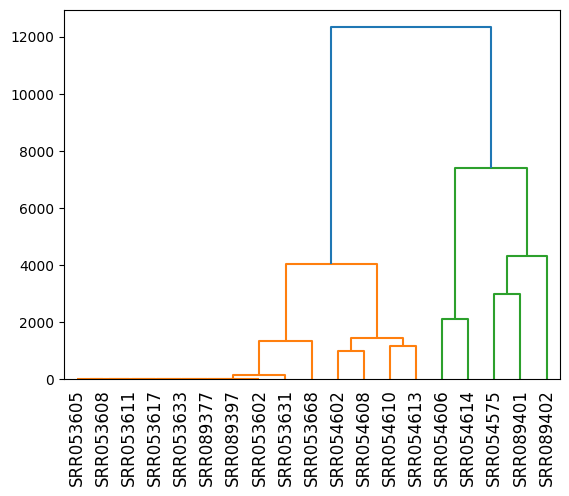

In [ ]:
Z, labels = complete_cluster(dist)
plt.figure()
dn = hierarchy.dendrogram(Z, labels=labels, leaf_rotation=90)
plt.show()

In [ ]:
# HIDDEN TEST CELL DO NOT MODIFY
